# Pettijohn et al., 2016
Here, we are simulating the findings of Pettijon, et al. (2016) where the main finding was that a list of items broken up into multiple events were remembered better as a whole than an equivalent list studied in a single event

## Description of the original Experiment
Subjects were given a list of 40 words to remember while moving between four locations in physical space, divided into 4 ordered sub-lists of 10 words each. Subjects read one sub-list (10 words) then moved to a new location in space, either in a new room (shift condition) or a new space in the same room (no-shift condition) that was equated for physical distance, and read a second sub-list (10 words). Subjects were then given a distractor task, then asked to recall as many of the words as possible from both tested sub-lists.  Then the procedure was repeated with the second set of sub-lists. People were more accurate when there was a shift (main effect, ANOVA) but there was no effect of boundary X shift interaction (ANOVA, two words before and after a shift)


## Description of the simulations
Here, we generate a list of $n=20$ items $\mathbf{x} \in \mathbb{R}^d$ by drawing each as a random Gaussian vector $\mathbf{x}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ in high (d-)dimensional space, such that each item is approximately orthogonal. We will assume these are either encoded within a single event (simulating the no-switch condition) or in two events (simulating the switch condition) and evaluate the recall of all of the items for both conditions. 



# Simluations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from models import *
from tqdm import tnrange
from simulations.exp_pettijohn import generate_task, batch

sns.set_context('paper', font_scale=1.5)

TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


Using TensorFlow backend.


train either one or two event models on the list of words

In [2]:
# set the parameters, all of them!

# SEM parameters
df0 = 100
scale0 = .2

lmda = 1.0  # stickyness parameter
alfa = 1.  # concentration parameter

f_class = KerasLSTM
f_opts=dict(var_scale0=scale0, var_df0=df0)

# create the corrupted memory trace
# noise parameters
b = 2
tau = 0.1
print("tau: {}".format(tau))

# set the parameters for the Gibbs sampler
gibbs_kwargs = dict(
    memory_alpha = 0.1,
    memory_lambda = 1.0,
    memory_epsilon = np.exp(-11),
    b = b,  # re-defined here for completeness
    tau = tau,  # ibid
    n_samples = 250,
    n_burnin = 100,
    leave_progress_bar=False,
)

epsilon_e = 0.25

tau: 0.1


In [3]:
# Calibrate the prior
x_list_no_switch, x_list_switch = generate_task()

mode = df0 * scale0 / (df0 + 2)
print("Prior variance (mode): {}".format(mode))
print("Median Feature variance: {}".format(np.median(np.var(x_list_no_switch[0], axis=0))))

sem_kwargs = dict(
    lmda=lmda, alfa=alfa, f_class=f_class,
    f_opts=f_opts
)
sem = SEM(**sem_kwargs)
sem.run_w_boundaries(list_events=x_list_switch)
print(sem.results.e_hat)

Prior variance (mode): 0.196078431373
Median Feature variance: 0.0344639961573


Run SEM: 100%|██████████| 2/2 [00:13<00:00,  6.76s/it]

[0 1]


In [4]:
from tqdm import tnrange
n_batch = 25

results = []
for ii in tnrange(n_batch, desc='Batch'):
    results.append(batch(sem_kwargs, gibbs_kwargs, epsilon_e, ii))
results = pd.concat(results)

exp_pettijohn.py:121: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  }, index=[batch_number])])


Ttest_indResult(statistic=5.957385605289281, pvalue=2.912448418131453e-07)

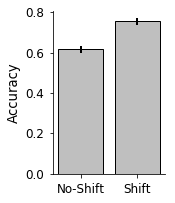

In [5]:
x = results.groupby('Condition').mean()['Overall Acc'].index
y = results.groupby('Condition').mean()['Overall Acc']
y_err = results.groupby('Condition').std()['Overall Acc'] / np.sqrt(n_batch)
plt.figure(figsize=(2, 3))
plt.bar(x, y, lw=1, edgecolor='k', facecolor=[0.75,0.75,0.75])
plt.errorbar(x, y, y_err, marker='None', lw=2, ls='None', c='k')
plt.ylabel('Accuracy')
sns.despine()

from scipy.stats import ttest_ind
ttest_ind(
    results.loc[results.Condition == 'Shift', 'Overall Acc'],
    results.loc[results.Condition == 'No-Shift', 'Overall Acc']
)

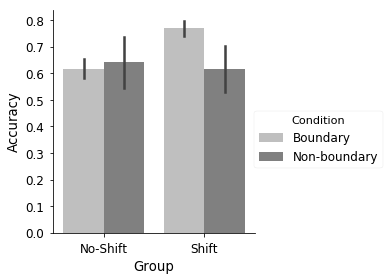

In [6]:
res = results.copy()
res.rename(columns={'Boundary Acc':'Boundary', 'Non-boundary Acc':'Non-boundary', 'Condition': 'Group'}, inplace=True)
res = res.melt(id_vars=['Group'], value_vars=['Boundary', 'Non-boundary'], value_name='Accuracy', 
               var_name='Condition')
sns.factorplot(data=res, y='Accuracy', x='Group', hue='Condition', 
               kind='bar', order=['No-Shift', 'Shift'],
               palette=[[0.75,0.75,0.75], [0.5,0.5,0.5]])

In [7]:
results.loc[results.Condition == 'Shift'].describe()

,Batch,Boundary Acc,Non-boundary Acc,Overall Acc,Reconstruction Segementation,r2
count,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000
mean,12.000000,0.770427,0.614160,0.75480,0.758440,0.800000
std,7.359801,0.074674,0.225592,0.07701,0.087199,0.408248
min,0.000000,0.551556,0.196000,0.52680,0.606000,0.000000
25%,6.000000,0.744444,0.456000,0.72240,0.692800,1.000000
50%,12.000000,0.773778,0.606000,0.75220,0.754600,1.000000
75%,18.000000,0.822000,0.800000,0.81840,0.824800,1.000000
max,24.000000,0.867778,0.980000,0.86360,0.902600,1.000000


Text(0,0.5,'Shift Accuracy')

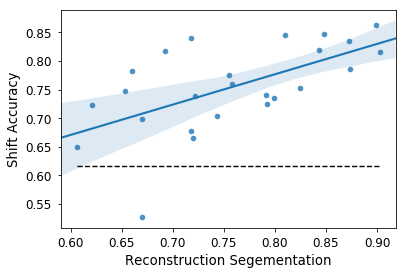

In [8]:
x = results.loc[results.Condition == 'Shift', 'Reconstruction Segementation']
y = results.loc[results.Condition == 'Shift', 'Overall Acc'].values
sns.regplot(x, y)
y_bar = np.mean(results.loc[results.Condition != 'Shift', 'Overall Acc'])
plt.plot([x.min(), x.max()], [y_bar, y_bar], 'k', ls='--')
plt.ylabel('Shift Accuracy')

Try to understand the how the parameter space effects the recovered segmentation

Text(0,0.5,'Shift Accuracy')

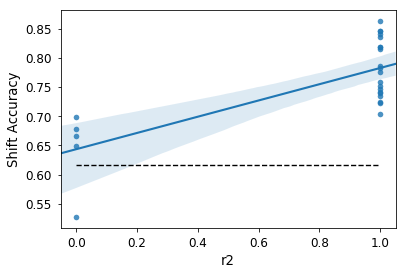

In [9]:
x = results.loc[results.Condition == 'Shift', 'r2']
y = results.loc[results.Condition == 'Shift', 'Overall Acc'].values
sns.regplot(x, y)
y_bar = np.mean(results.loc[results.Condition != 'Shift', 'Overall Acc'])
plt.plot([x.min(), x.max()], [y_bar, y_bar], 'k', ls='--')
plt.ylabel('Shift Accuracy')

In [10]:
np.mean(y[x == 1.])

0.7826500000000001